# Example: Solving the one dimensional Poisson equation



## What we must find numerically 

* Use what we know about the function's derivatives in order to approximate the function values within a domain.

## The usage of neural network 

* We must propose a trial solution
* The trial solution should satisfy the given boundary conditions 
* Include output from the neural net in the trial solution

## One dimensional Poisson equation 

Here, the function $g(x)$ to solve for follows the equation 

$$ \label{ode}
-g''(x) = f(x),\qquad \qquad x \in (0,1)
$$

for a given $f(x)$ is a given function, along with some chosen boundary conditions.

In this case, we let:

* $f(x) = (3x + x^2)\exp(x)$

* Boundary conditions: $g(0) = g(1) = 0$


## Trial solution 

A possible trial solution:

$$g_{trial}(x) = x(1 - x)N(x, P)$$

with $N(x, P)$ being the output from the network at $x$ with weights and biases for every layer contained in $P$. 

---

**we want to find $g_{trial}$ such that**

$$-g_{trial}''(x) = f(x)$$

**holds as best as possible!**

---

## Using TensorFlow to solve our Poisson equation 

* Construction phase 

* Execution phase 

## Construction phase - set everything up 

In [1]:
import numpy as np 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.set_random_seed(4155)

# Just to reset the graph such that it is possible to rerun this
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()

Nx = 10
x = np.linspace(0,1, Nx)

x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)

num_iter = 10000

num_hidden_neurons = [20,10]
num_hidden_layers = len(num_hidden_neurons)

Instructions for updating:
non-resource variables are not supported in the long term


## Construction phase - construct the network

In [2]:
# Input layer
previous_layer = x_tf
    
# Hidden layers
for l in range(num_hidden_layers):
    current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], activation=tf.nn.sigmoid)
    previous_layer = current_layer
    
# Output layer
dnn_output = tf.layers.dense(previous_layer, 1)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## Construction phase - define the cost function 

In [3]:
g_trial = x_tf*(1 - x_tf)*dnn_output
d_g_trial = tf.gradients(g_trial,x_tf)
d2_g_trial = tf.gradients(d_g_trial,x_tf)

# f(x)
right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)

err = tf.square( -d2_g_trial[0] - right_side)
cost = tf.reduce_sum(err)

## Construction phase - specify the optimization method

In [4]:
learning_rate = 0.001

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
traning_op = optimizer.minimize(cost)

## Execution phase - train the network and evaluate the final model

In [5]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    
    # Evaluate the initial cost:
    print('Initial cost: %g'%cost.eval())
    
    for i in range(num_iter):
        sess.run(traning_op)
    
    print('Final cost: %g'%cost.eval())
    
    g_dnn_tf_descent = g_trial.eval()

Initial cost: 258.447
Final cost: 0.011711


## Solving the equation using finite differences

A possible approximation to the second derivative of a function is 

$$ g''(x_i) \approx \frac{g(x_i + \Delta x) - 2g(x_i) + g(x_i - \Delta x)}{(\Delta x)^2} $$

for $i = 1, \dots, N_x - 2$ and $g(x_0) = g(x_{N_x -1}) = 0$.


Inserting this into the Poisson equation yields the following linear system:

$$
\begin{aligned}
\begin{pmatrix}
2 & -1 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
\vdots & & \ddots & & \vdots \\
0 & \dots & -1 & 2 & -1 \\
0 & \dots & 0 & -1 & 2
\end{pmatrix}
\begin{pmatrix}
g(x_1) \\
g(x_2) \\
\vdots \\ 
g(x_{N_x - 3}) \\
g(x_{N_x - 2})
\end{pmatrix}
&=
(\Delta x)^2
\begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\ 
f(x_{N_x - 3}) \\
f(x_{N_x - 2})
\end{pmatrix} 
\\
A\vec{g} &= \vec{f}
\end{aligned}
$$

In [12]:
dx = 1/(Nx-1)

# Set up the matrix A
Nx2 = Nx - 2
A = np.zeros((Nx2,Nx2))

A[0,0] = 2
A[0,1] = -1

for i in range(1,Nx2-1):
    A[i,i-1] = -1
    A[i,i] = 2
    A[i,i+1] = -1

A[Nx2 - 1, Nx2 - 2] = -1
A[Nx2 - 1, Nx2 - 1] = 2

# Set up the vector f
def f(x):
    return (3*x + x**2)*np.exp(x)

f_vec = dx**2 * f(x[1:-1])

# Solve the equation
g_res = np.linalg.solve(A,f_vec)

# Insert the solution into an array
g_vec = np.zeros(Nx)
g_vec[1:-1] = g_res

## Results: Neural network versus finite differences

The analytic solution for our equation is

$$
g(x) = x(1 - x)\exp(x)
$$

In [13]:
g_analytical = x*(1-x)*np.exp(x)

### Solution from finite differences:

In [14]:
print("Max absolute error between analytical and finite difference: %g"%np.max(np.abs(g_vec - g_analytical)))

Max absolute error between analytical and finite difference: 0.00266858


### Solution from neural network (gradient descent):

In [15]:
diff_tf = g_dnn_tf_descent - g_analytical.reshape(-1,1)
print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN\nusing gradient descent: %g'%np.max(np.abs(diff_tf)))


Max absolute difference between the analytical solution and solution from TensorFlow DNN
using gradient descent: 0.000856032


### Plotting the results 

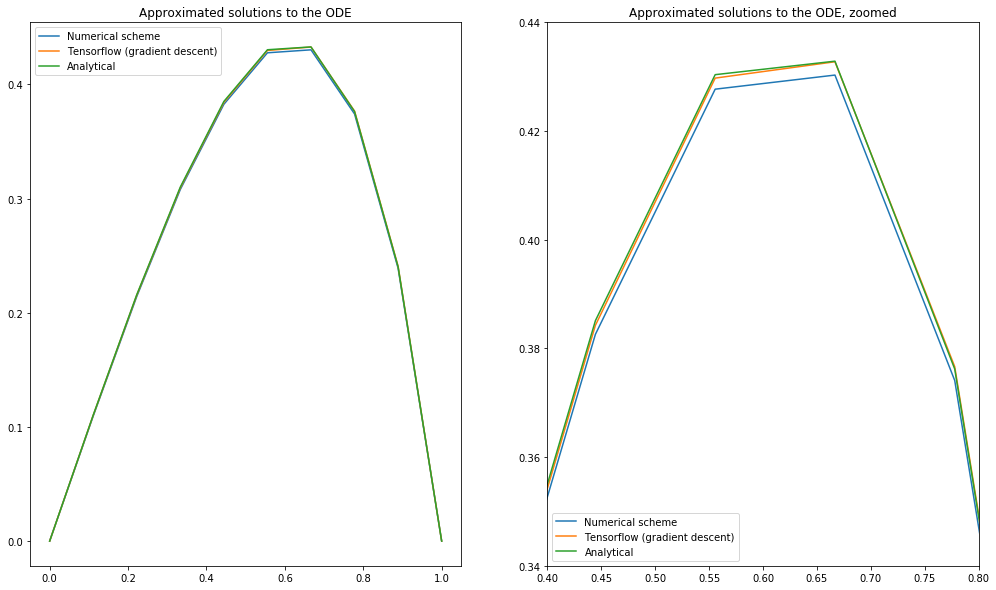

In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt 

plt.figure(figsize=(17,10))

plt.subplot(1,2,1)

plt.title("Approximated solutions to the ODE")
plt.plot(x, g_vec)
plt.plot(x, g_dnn_tf_descent)
plt.plot(x, g_analytical)

plt.legend(['Numerical scheme', 'Tensorflow (gradient descent)', 'Analytical'])

plt.subplot(1,2,2)

plt.title("Approximated solutions to the ODE, zoomed")
plt.plot(x, g_vec)
plt.plot(x, g_dnn_tf_descent)
plt.plot(x, g_analytical)

plt.xlim([0.4, 0.8])
plt.ylim([0.34, 0.44])

plt.legend(['Numerical scheme', 'Tensorflow (gradient descent)', 'Analytical'])

plt.show()

## Using a different optimization algorithm implemented in TensorFlow

We can see that the results using Gradient Descent seems to converge towards the analytical solution. 
But there exists many other methods for optimization also, see [the TensorFlow documentation](https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers). 

Adam is an optimization algorithm that is adaptive and changes its learning paramaters accordingly to the function it tries to minimize. The algorithm is described in [this paper](https://arxiv.org/pdf/1412.6980.pdf). Here, we will only see the effect of choosing a different optimizer. 
Using the same TensorFlow program as before, the only change to do, is to replace the variable \textit{optimizer}.

In [17]:
tf.reset_default_graph()
tf.set_random_seed(4155)

x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)


num_iter = 10000

num_hidden_neurons = [20,10]
num_hidden_layers = np.size(num_hidden_neurons)

previous_layer = x_tf

for l in range(num_hidden_layers):
    current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1), activation=tf.nn.sigmoid)
    previous_layer = current_layer
    
dnn_output = tf.layers.dense(previous_layer, 1, name='output')


g_trial = x_tf*(1-x_tf)*dnn_output
d_g_trial = tf.gradients(g_trial,x_tf)
d2_g_trial = tf.gradients(d_g_trial,x_tf)
    
right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)
    
err = tf.square( -d2_g_trial[0] - right_side)
cost = tf.reduce_sum(err, name = 'cost')

learning_rate = 0.001

## This line has changed
optimizer = tf.train.AdamOptimizer(learning_rate) 
##

traning_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()

    print('Initial cost: %g'%cost.eval())

    for i in range(num_iter):
        sess.run(traning_op)

    print('Final cost: %g'%cost.eval())

    g_dnn_tf_adam = g_trial.eval()
    

Initial cost: 324.099
Final cost: 0.000345773


### Results from TensorFlow using the Adam optimizer

In [18]:
diff_tf_adam = g_dnn_tf_adam - g_analytical.reshape(-1,1)
print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN using Adam: %g'%np.max(np.abs(diff_tf_adam)))
print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN\nusing gradient descent: %g'%np.max(np.abs(diff_tf)))
print("\nMax absolute error between analytical and finite difference: %g"%np.max(np.abs(g_vec - g_analytical)))


Max absolute difference between the analytical solution and solution from TensorFlow DNN using Adam: 7.11243e-05

Max absolute difference between the analytical solution and solution from TensorFlow DNN
using gradient descent: 0.000856032

Max absolute error between analytical and finite difference: 0.00266858


## References

* [Artificial neural networks for solving ordinary and partial differential equations by I.E. Lagaris et al](https://pdfs.semanticscholar.org/d061/df393e0e8fbfd0ea24976458b7d42419040d.pdf)

* [Neural networks for solving differential equations by A. Honchar](https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c)

* [Solving differential equations using neural networks by M.M Chiaramonte and M. Kiener](http://cs229.stanford.edu/proj2013/ChiaramonteKiener-SolvingDifferentialEquationsUsingNeuralNetworks.pdf)

* [Introduction to Partial Differential Equations by A. Tveitio, R. Winther](https://www.springer.com/us/book/9783540225515)
